# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 04.11.2022

Мягкий дедлайн: 23:59MSK 16.11.2022

Жесткий дедлайн: 23:59MSK 23.11.2022

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей

In [21]:
!pip install --upgrade scikit-learn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [23]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт один из двух классов с равными вероятностями. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [24]:
np.random.seed(42)

# наш случайный классификатор
y_random = np.random.choice([0, 1], size=len(y_test), p=[0.5, 0.5])
y_random

array([0, 1, 1, ..., 0, 0, 1])

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно, за особенно эффективные или красивые варианты может быть начислен небольшой бонус :)

In [25]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

In [26]:
def show_curves(name: str, y, y_pred):
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    PrecisionRecallDisplay.from_predictions(y, y_pred, ax=ax[0])
    precision, recall, _ = precision_recall_curve(y, y_pred)
    auc_pr = auc(recall, precision)
    print('AUC-PR: %.5f' % auc_pr)
    ax[0].set_title(name)
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y, y_pred, ax=ax[1])
    auc_roc = roc_auc_score(y, y_pred)
    print('AUC-ROC: %.5f' % auc_roc)
    ax[1].set_title(name)
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    
    return auc_pr, auc_roc


AUC-PR: 0.63340
AUC-ROC: 0.50394


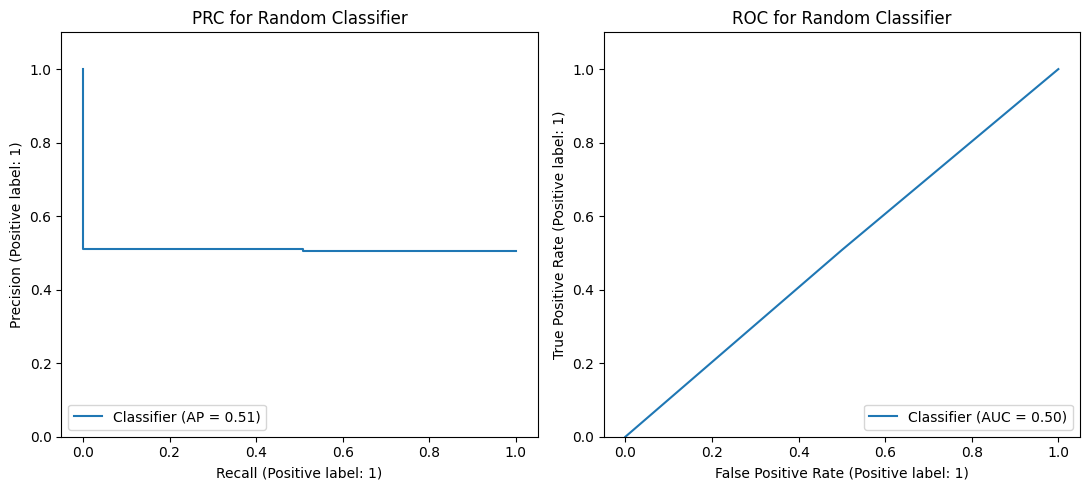

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test, y_random, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, y_random)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PRC for Random Classifier")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, y_random, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, y_random))
ax[1].set_title("ROC for Random Classifier")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

In [28]:
# dataframe для сравнения 
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])

# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
    auc(recall, precision),
    roc_auc_score(y_test, y_random),
    None
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN


In [29]:
def get_metrics(y, y_pred):
    df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
    precision, recall, _ = precision_recall_curve(y, y_pred)

    # добавление очередной строки с характеристиками метода
    
    return auc(recall, precision),  roc_auc_score(y, y_pred)

__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).

__NB!__ Здесь и далее, если не сказано иначе, подбирайте __оптимальные гиперпараметры с точки зрения AUC-PR.__

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [31]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

cs = np.logspace(-7, 1, 10)
val_scores = []

for c in cs:
    svc = LinearSVC(max_iter=100000, C=c).fit(X_train, y_train)
    svc_pred = svc.decision_function(X_val)
    auc_pr, auc_roc = get_metrics(y_val, svc_pred)
    print('AUC_PR SCORE:', auc_pr)
    val_scores.append(auc_pr)

max_idx = np.argmax(val_scores)
best_c = cs[max_idx]
print(f"BEST C IS {best_c}")
best_svc = LinearSVC(max_iter=100000, C=best_c).fit(X_train, y_train)

AUC_PR SCORE: 0.7994896368047417
AUC_PR SCORE: 0.8018160705056695
AUC_PR SCORE: 0.8112027910920401
AUC_PR SCORE: 0.8083193991195616
AUC_PR SCORE: 0.8002390981430273
AUC_PR SCORE: 0.7998457866280726
AUC_PR SCORE: 0.7997264384684949
AUC_PR SCORE: 0.7996898436922081
AUC_PR SCORE: 0.7996920318533525
AUC_PR SCORE: 0.7996935071331399
BEST C IS 5.994842503189409e-06


AUC-PR: 0.82517
AUC-ROC: 0.82937


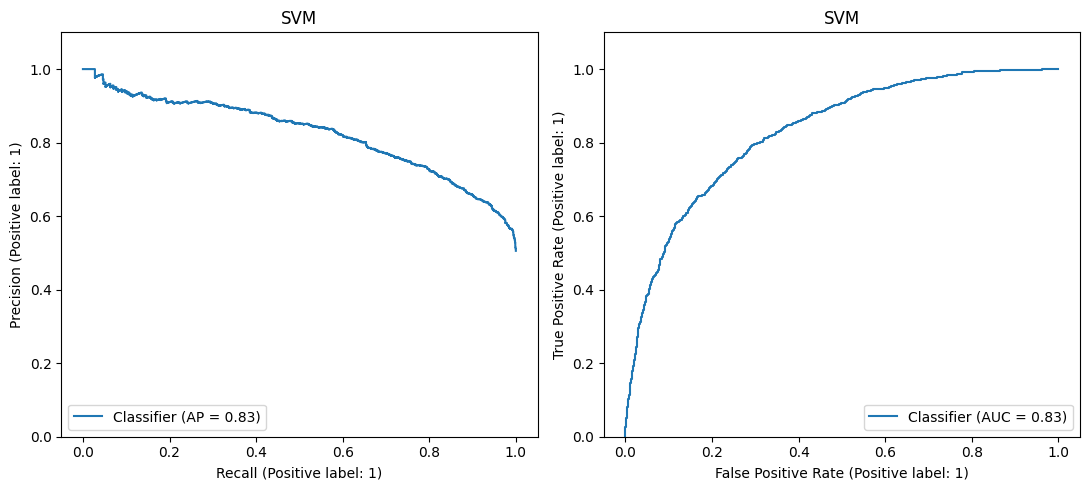

In [32]:
best_svc = LinearSVC(max_iter=100000, C=best_c).fit(X_train, y_train)
auc_pr, auc_roc = show_curves("SVM", y_test, best_svc.decision_function(X_test))

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [33]:


df_metrics.loc['SVM'] = [
    auc_pr,
    auc_roc,
    f"C = {best_c}"
]


# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN
SVM,0.825166,0.829371,C = 5.994842503189409e-06


__Logistic Regression__

Теперь повторите то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление метрик и построение кривых ROC и PR.

In [34]:
cs = np.logspace(-20, 1, 20)
val_scores = []

for c in cs:
    lr = LogisticRegression(max_iter=100000, C=c).fit(X_train, y_train)
    val_pred = lr.decision_function(X_val)
    auc_pr, auc_roc = get_metrics(y_val, val_pred)
    print('AUC_PR SCORE:', auc_pr)
    val_scores.append(auc_pr)

max_idx = np.argmax(val_scores)
best_c = cs[max_idx]
print(f"BEST C IS {best_c}")
best_lr = LogisticRegression(max_iter=100000, C=best_c).fit(X_train, y_train)

AUC_PR SCORE: 0.799036405549292
AUC_PR SCORE: 0.799036405549292
AUC_PR SCORE: 0.799036405549292
AUC_PR SCORE: 0.799036405549292
AUC_PR SCORE: 0.799036405549292
AUC_PR SCORE: 0.799036405549292
AUC_PR SCORE: 0.799036405549292
AUC_PR SCORE: 0.7991507489101388
AUC_PR SCORE: 0.7991434078528319
AUC_PR SCORE: 0.7995581305693227
AUC_PR SCORE: 0.7991449236421875
AUC_PR SCORE: 0.7991416627752209
AUC_PR SCORE: 0.7991460357853578
AUC_PR SCORE: 0.799897008125007
AUC_PR SCORE: 0.8071182048461596
AUC_PR SCORE: 0.8140288720872202
AUC_PR SCORE: 0.8021082139945976
AUC_PR SCORE: 0.7993257239734672
AUC_PR SCORE: 0.7992071718355603
AUC_PR SCORE: 0.7991962377934749
BEST C IS 0.00037926901907322694


AUC-PR: 0.83398
AUC-ROC: 0.84125


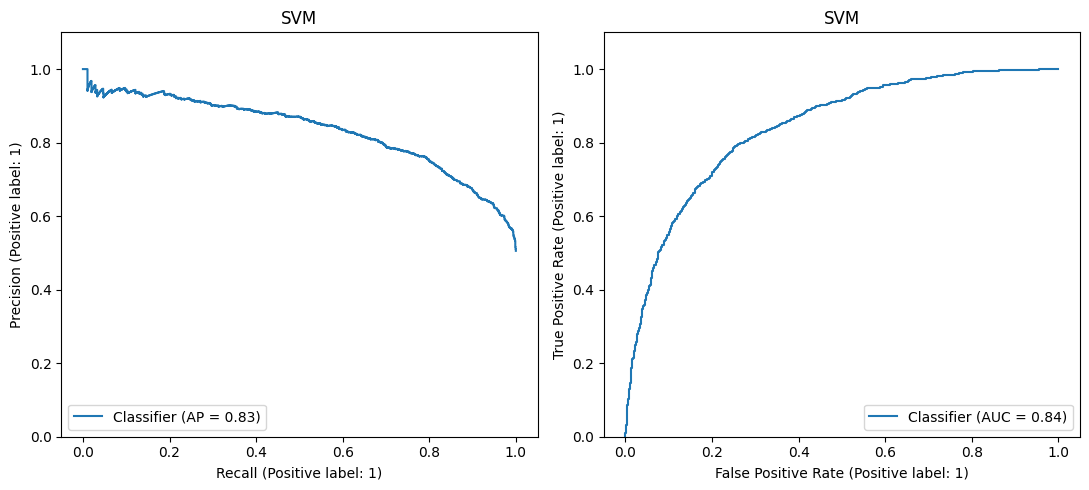

In [35]:
best_lr = LogisticRegression(max_iter=100000, C=best_c).fit(X_train, y_train)
auc_pr, auc_roc = show_curves("SVM", y_test, best_lr.decision_function(X_test))

In [36]:
df_metrics.loc['LR'] = [
    auc_pr,
    auc_roc,
    f"C = {best_c}"
]


# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN
SVM,0.825166,0.829371,C = 5.994842503189409e-06
LR,0.833981,0.841246,C = 0.00037926901907322694


__Микровывод__

  Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

  Ответ: Видим, что различия на сгенерированных данных минимально. Это, конечно, не очень согласуется с теорией, потому что на лекции говорилось, что SVM должен быть лучше по именно этим метрикам, потому что он именно на них заточен, но жизнь такова какова она есть и больше никакова, поэтому имеем то, что имеем. 

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)

В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

1) Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет.

2) Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`). 

In [37]:
X, y = make_classification(
    n_samples=500, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [38]:
from sklearn.svm import SVC

cs = np.logspace(-7, 1, 10)
val_scores = []

for c in cs:
    svc = SVC(kernel='linear', C=c).fit(X_train, y_train)
    svc_pred = svc.decision_function(X_val)
    auc_pr, auc_roc = get_metrics(y_val, svc_pred)
    print('AUC_PR SCORE:', auc_pr)
    val_scores.append(auc_pr)

max_idx = np.argmax(val_scores)
best_c = cs[max_idx]
print(f"BEST C IS {best_c}")

AUC_PR SCORE: 0.8376545727060258
AUC_PR SCORE: 0.8376545727060258
AUC_PR SCORE: 0.8376545727060258
AUC_PR SCORE: 0.8380264841555951
AUC_PR SCORE: 0.8380264841555951
AUC_PR SCORE: 0.8376545727060258
AUC_PR SCORE: 0.8614720350006088
AUC_PR SCORE: 0.8865877156692249
AUC_PR SCORE: 0.910493006340456
AUC_PR SCORE: 0.9130505678265889
BEST C IS 10.0


In [39]:
best_svc = SVC(kernel='linear', C=best_c).fit(X, y)

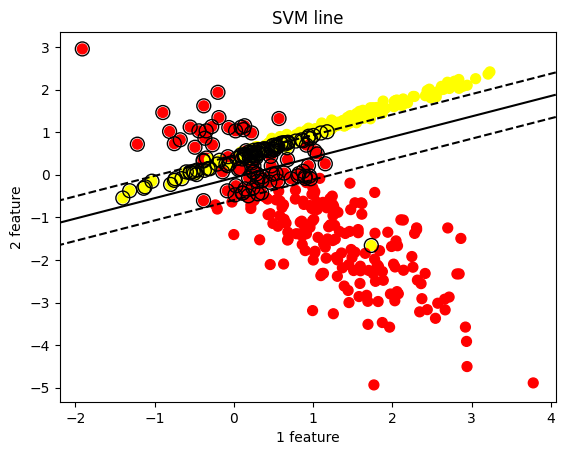

In [40]:
ax = plt.gca()
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = best_svc.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=1,
           linestyles=['--', '-', '--'])

ax.scatter(best_svc.support_vectors_[:, 0], best_svc.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.title("SVM line")
plt.xlabel("1 feature")
plt.ylabel("2 feature")
plt.show()

Обведены опорные вектора, сплошная линия -- линия разделения классов, две пунктирные линии -- просто так (-1 и +1 от сплошной)

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor` ([matplotlib demo](https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/pcolor_demo.html#sphx-glr-gallery-images-contours-and-fields-pcolor-demo-py)).

Text(0, 0.5, '2 feature')

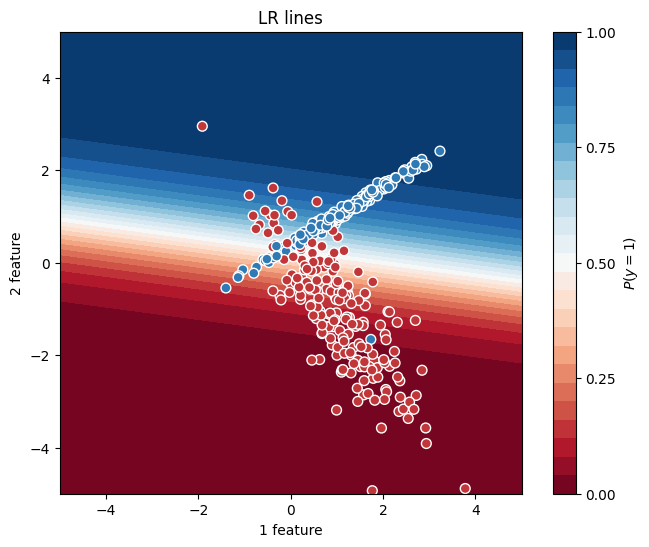

In [41]:
clf = LogisticRegression(max_iter=100000, C=0.1).fit(X, y)

xx, yy = np.mgrid[-5:5:.01, -5:5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)

f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal",
       xlim=(-5, 5), ylim=(-5, 5),
       xlabel="$X_1$", ylabel="$X_2$")

plt.title("LR lines")
plt.xlabel("1 feature")
plt.ylabel("2 feature")

#### __Задание 2. Калибровка вероятностей__ (1 балл)

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [42]:
def plot_calibration_curve(y_test, preds, name):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2) 
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1)) 
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()
    plt.title(name)
    plt.xlabel("mean predicted probability")
    plt.ylabel("fraction of positives")
    plt.show()
    

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

In [43]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [44]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

cs = np.logspace(-7, 1, 10)
val_scores = []

for c in cs:
    svc = LinearSVC(max_iter=100000, C=c).fit(X_train, y_train)
    svc_pred = svc.decision_function(X_val)
    auc_pr, auc_roc = get_metrics(y_val, svc_pred)
    print('AUC_PR SCORE:', auc_pr)
    val_scores.append(auc_pr)

max_idx = np.argmax(val_scores)
best_c = cs[max_idx]
print(f"BEST C IS {best_c}")
best_svc = LinearSVC(max_iter=100000, C=best_c).fit(X_train, y_train)

AUC_PR SCORE: 0.792590394304824
AUC_PR SCORE: 0.7947832032099267
AUC_PR SCORE: 0.8051375392741384
AUC_PR SCORE: 0.8088136575344328
AUC_PR SCORE: 0.8034041836322449
AUC_PR SCORE: 0.8040116393673864
AUC_PR SCORE: 0.8041436911280635
AUC_PR SCORE: 0.8041840264987943
AUC_PR SCORE: 0.804191717546706
AUC_PR SCORE: 0.8041927978872535
BEST C IS 4.641588833612772e-05


In [45]:
cs = np.logspace(-20, 1, 20)
val_scores = []

for c in cs:
    lr = LogisticRegression(max_iter=100000, C=c).fit(X_train, y_train)
    val_pred = lr.decision_function(X_val)
    auc_pr, auc_roc = get_metrics(y_val, val_pred)
    print('AUC_PR SCORE:', auc_pr)
    val_scores.append(auc_pr)

max_idx = np.argmax(val_scores)
best_c = cs[max_idx]
print(f"BEST C IS {best_c}")
best_lr = LogisticRegression(max_iter=100000, C=best_c).fit(X_train, y_train)

AUC_PR SCORE: 0.7922281769495478
AUC_PR SCORE: 0.7922281769495478
AUC_PR SCORE: 0.7922281769495478
AUC_PR SCORE: 0.7922281769495478
AUC_PR SCORE: 0.7922281769495478
AUC_PR SCORE: 0.7922281769495478
AUC_PR SCORE: 0.7922281769495478
AUC_PR SCORE: 0.7922281769495478
AUC_PR SCORE: 0.7921124681283837
AUC_PR SCORE: 0.7921109906677094
AUC_PR SCORE: 0.7921079690068604
AUC_PR SCORE: 0.7921047958649818
AUC_PR SCORE: 0.7921773519169153
AUC_PR SCORE: 0.7929789824935198
AUC_PR SCORE: 0.8003429002921868
AUC_PR SCORE: 0.8131816340815243
AUC_PR SCORE: 0.805891923442223
AUC_PR SCORE: 0.8033517539019874
AUC_PR SCORE: 0.8031697127545699
AUC_PR SCORE: 0.8031648265819306
BEST C IS 0.00037926901907322694


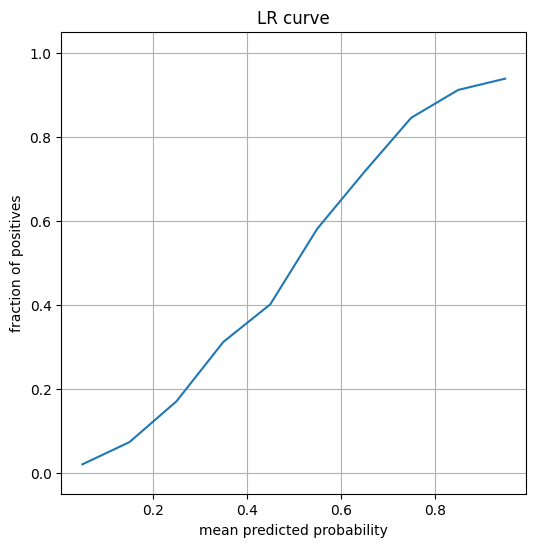

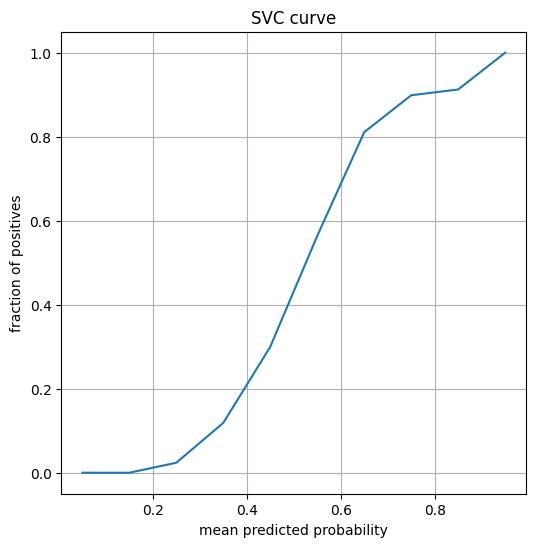

In [46]:
plot_calibration_curve(y_test, best_lr.predict_proba(X_test)[:, 1], "LR curve")

svc_pred =  best_svc.decision_function(X_test)
svc_pred = (svc_pred - svc_pred.min()) / (svc_pred.max() - svc_pred.min())
plot_calibration_curve(y_test, svc_pred, "SVC curve")

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

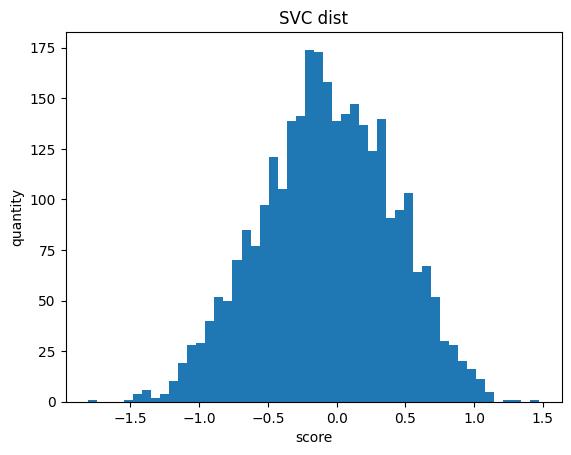

In [47]:
plt.hist(best_svc.decision_function(X_test), bins=50)
plt.title("SVC dist")
plt.xlabel("score")
plt.ylabel("quantity")
plt.show()

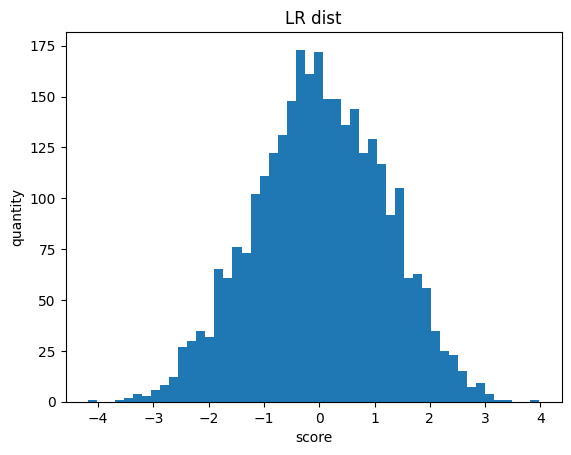

In [48]:
plt.hist(best_lr.decision_function(X_test), bins=50)
plt.title("LR dist")
plt.xlabel("score")
plt.ylabel("quantity")
plt.show()


Чем они различаются? Чем вы можете объяснить это?

Ответ: В целом видно, что оба распределения похожи между собой и похожи на нормальное. Отличие следующее: у LR больше отрезок возможных значений. Мне кажется, это связано с тем, что LR предсказывает нам логиты, которые надо бы запихнуть в сигмоиду, поэтому ему важно уметь выражать разные степени уверенности, а для этого хорошо, когда больше значений принимается, а SVC по существу важен знак скалярного произведения с весами, поэтому разброс поменьше

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

In [49]:
from sklearn.calibration import CalibratedClassifierCV
sigmoid_svc = CalibratedClassifierCV(best_svc, cv=3, method='sigmoid').fit(X_train, y_train)
sigmoid_svc_pred = sigmoid_svc.predict_proba(X_test)[:, 1]

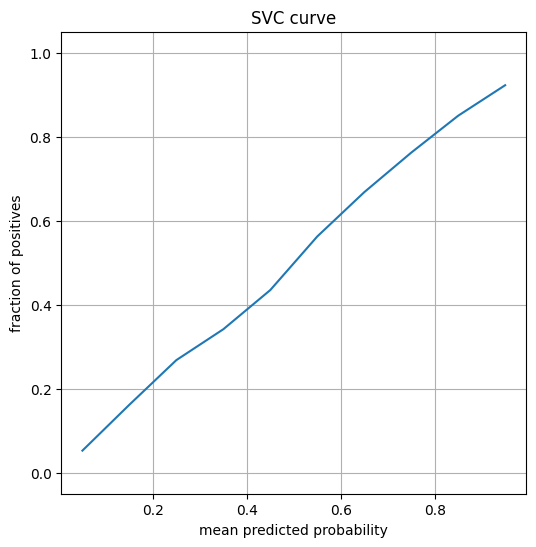

In [50]:
plot_calibration_curve(y_test, sigmoid_svc_pred, "SVC curve")

Да, видим, что кривая сильно улучшилась, супер

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [51]:
#your code here

# Часть 2. Обработка категориальных переменных

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла. 

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет. 

In [5]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2022-11-21 16:00:05--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.252
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 3974305 (3,8M) [application/x-httpd-php]
Сохранение в: «adult.data.2»

adult.data.2        100%[===================>]   3,79M   652KB/s    за 7,9s    

2022-11-21 16:00:14 (493 KB/s) - «adult.data.2» сохранён [3974305/3974305]



In [52]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain', 
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')

In [53]:
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0


Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. 

In [54]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, "age" :"native-country"], df['income'], test_size=0.25, random_state=777, stratify=df['income'])

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`, а числовые признаки нормализуйте с помощью `StandardScaler`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [55]:
categorical = ['workclass', 'education', 
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'native-country']

numeric = ['age',  'fnlwgt', 'capital-gain', 
           'capital-loss', 'hours-per-week']

In [56]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from datetime import datetime

column_transformer = ColumnTransformer([
    ('ohe', OrdinalEncoder(), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=100000))
])

begin = datetime.now()
model = pipeline.fit(X_train, y_train)
print(f"Encoding + learning time : {(datetime.now() - begin).total_seconds()} seconds")
y_pred = model.predict(X_test)

Encoding + learning time : 1.201378 seconds


In [57]:
auc_pr, auc_roc = get_metrics(y_test, y_pred)
print(f"AUC PR : {auc_pr}")

AUC PR : 0.6401982820216694


In [58]:
print(f"Доля людей с достатком < 50 : {len(y_train[y_train == 0]) / len(y_train)}")

Доля людей с достатком < 50 : 0.7591728091728092


__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ответ__:  Видим, что у нас есть дисбаланс в классах: доля людей с достатком меньше 50 тыс сильно больше, поэтому нам нужно использовать метрику, которая более устойчива к дисбалансу классов, а это как раз AUC-PR, так как PR кривая по осям имеет precision и recall, то там как бы не учитываются TN (true negative), а это хорошо, потому что нам важнее разобраться именно с хорошим предсказанием положительного класса (вообще на семинарах обсуждали это)

#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [64]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from datetime import datetime

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=100000))
])

begin = datetime.now()
model = pipeline.fit(X_train, y_train)
print(f"Encoding + learning time : {(datetime.now() - begin).total_seconds()} seconds")
y_pred = model.predict(X_test)

Encoding + learning time : 1.278482 seconds


In [62]:
auc_pr, auc_roc = get_metrics(y_test, y_pred)
print(f"AUC PR : {auc_pr}")

AUC PR : 0.7188541128820272


 Видим, что целевая метрика ощутимо выросла, отлично! 

Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [69]:
!pip3 install category_encoders

--- Logging error ---
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pip/_vendor/rich/console.py", line 1673, in print
    extend(render(renderable, render_options))
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pip/_vendor/rich/console.py", line 1305, in render
    for render_output in iter_render:
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for line in lines:
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pip/_vendor/rich/segment.py", line 249, in split_lines
    for segment in segments:
  File "/Library/

In [70]:
from category_encoders import TargetEncoder

In [95]:
column_transformer = ColumnTransformer([
    ('te', TargetEncoder(), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=100000))
])

begin = datetime.now()
model = pipeline.fit(X_train, y_train)
print(f"Encoding + learning time : {(datetime.now() - begin).total_seconds()} seconds")
y_pred = model.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


Encoding + learning time : 5.321692 seconds


Получается подольше, чем в предыдущие разы

In [67]:
auc_pr, auc_roc = get_metrics(y_test, y_pred)
print(f"AUC PR : {auc_pr}")

AUC PR : 0.7087533797576836


##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их. 

In [92]:
from sklearn.base import BaseEstimator, TransformerMixin

class MyTargetEncoder(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass
    
    def fit(self, X, y):
        print("Call fit")
        return self
    
    def transform(self, X):
        print("Call transform")
        print(X)
        return X
    

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

In [ ]:
#your code here

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [ ]:
#your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты.


In [111]:

column_transformer = ColumnTransformer([
    ('te', TargetEncoder(smoothing=50), categorical), #добавили сглаживание
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=100000))
])

begin = datetime.now()
model = pipeline.fit(X_train, y_train)
print(f"Encoding + learning time : {(datetime.now() - begin).total_seconds()} seconds")
y_pred = model.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."


Encoding + learning time : 6.504266 seconds


In [112]:
auc_pr, auc_roc = get_metrics(y_test, y_pred)
print(f"AUC PR : {auc_pr}")

AUC PR : 0.7097283347274135


Видим, что сглаживание немного помогло

#### __Задание 8. И все-таки числовой?__  (0.5 балла)

В данных имеются признаки "возраст" и "число рабочих часов в неделю". Сейчас мы интерпретируем их как числовые, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?



In [113]:
categorical = ['workclass', 'education', 
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'native-country', "age"] #добавляем age в категор

numeric = [  'fnlwgt', 'capital-gain', 
           'capital-loss', 'hours-per-week']



In [114]:

column_transformer = ColumnTransformer([
    ('te', TargetEncoder(smoothing=50), categorical), #добавили сглаживание
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=100000))
])

begin = datetime.now()
model = pipeline.fit(X_train, y_train)
print(f"Encoding + learning time : {(datetime.now() - begin).total_seconds()} seconds")
y_pred = model.predict(X_test)

auc_pr, auc_roc = get_metrics(y_test, y_pred)
print(f"AUC PR : {auc_pr}")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."


Encoding + learning time : 4.80995 seconds
AUC PR : 0.7092641219867264


Немного ухудшилось

In [115]:
categorical = ['workclass', 'education', 
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'native-country', 'hours-per-week'] # добавляем часов в неделю в категор

numeric = ["age", 'fnlwgt', 'capital-gain', 
           'capital-loss']



In [116]:

column_transformer = ColumnTransformer([
    ('te', TargetEncoder(smoothing=50), categorical), #добавили сглаживание
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=100000))
])

begin = datetime.now()
model = pipeline.fit(X_train, y_train)
print(f"Encoding + learning time : {(datetime.now() - begin).total_seconds()} seconds")
y_pred = model.predict(X_test)

auc_pr, auc_roc = get_metrics(y_test, y_pred)
print(f"AUC PR : {auc_pr}")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."


Encoding + learning time : 14.855095 seconds
AUC PR : 0.7102394795694145


Немного улучшилось

In [119]:
categorical = ['workclass', 'education', 
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'native-country', 'hours-per-week', "age"] # добавляем часов в неделю и возраст в категор

numeric = ['fnlwgt', 'capital-gain', 
           'capital-loss']



In [120]:

column_transformer = ColumnTransformer([
    ('te', TargetEncoder(smoothing=50), categorical), #добавили сглаживание
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=100000))
])

begin = datetime.now()
model = pipeline.fit(X_train, y_train)
print(f"Encoding + learning time : {(datetime.now() - begin).total_seconds()} seconds")
y_pred = model.predict(X_test)

auc_pr, auc_roc = get_metrics(y_test, y_pred)
print(f"AUC PR : {auc_pr}")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."


Encoding + learning time : 5.897104 seconds
AUC PR : 0.7092641219867264


По итогу, самым удачным решением было добавить только кол-во часов в неделю в категориальные признаки.

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ Ну плюс, очевидно, состоит в меньшем количестве памяти, которое необходимо для mean target, минусы такие: ohe все-таки поточнее будет как мне кажется, оно как-то больше информации сохраняет, также mte допускает утечку целевых переменных даже не смотря на все эти приседания + надо свой трансформер руками писать, чтобы все фичи добавлять, ужас какой-то.

# Часть 3. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тем же данным про предсказание дохода.

In [121]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain', 
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')

Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, "age" :"native-country"], df['income'], test_size=0.25, random_state=777, stratify=df['income'])

In [158]:
categorical = ['workclass', 'education', 
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'native-country']

numeric = ['fnlwgt', 'capital-gain', 
           'capital-loss',  'hours-per-week', "age"]

Давайте закодируем все категориальные признаки с помощью One-hot Encoding, считая возраст и число часов числовыми. Сколько новых признаков мы получим?

In [132]:
ohe = OneHotEncoder()
feature_num_after_ohe = ohe.fit_transform(X_train[categorical]).shape[1]
print(f"Количество признаков, после ohe выросло на: {feature_num_after_ohe - len(categorical + numeric)}")

Количество признаков, после ohe выросло на: 104


In [160]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from datetime import datetime

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=100000))
])

begin = datetime.now()
model = pipeline.fit(X_train, y_train)
print(f"Encoding + learning time : {(datetime.now() - begin).total_seconds()} seconds")
y_pred = model.predict(X_test)

Encoding + learning time : 1.902711 seconds


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [161]:
auc_pr, auc_roc = get_metrics(y_test, y_pred)
print(f"AUC PR : {auc_pr}")

AUC PR : 0.6748232919450121


#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [201]:
def get_most_important(a):
    a = list(a[0])
    a = list(zip(a, range(len(a))))
    a = sorted(a, key=lambda x : -abs(x[0]))
    res = []
    for i in range(40):
        res.append(a[i][1])
    return res

In [234]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
])

reg = LogisticRegression(max_iter=100000)


begin = datetime.now()
X_train_ohe = column_transformer.fit_transform(X_train).toarray()
X_train_ohe = np.concatenate((X_train_ohe, X_train[numeric].to_numpy()), axis=1)
print(f"shape before drop {X_train_ohe.shape}")
reg.fit(X_train_ohe, y_train)
best_features = get_most_important(reg.coef_)
X_train_ohe = X_train_ohe[:, best_features]
print(f"shape after drop {X_train_ohe.shape}")
reg.fit(X_train_ohe, y_train)
print(f"Encoding + learning time : {(datetime.now() - begin).total_seconds()} seconds")

X_test_ohe = column_transformer.transform(X_test).toarray()
X_test_ohe = np.concatenate((X_test_ohe, X_test[numeric].to_numpy()), axis=1)
y_pred = reg.predict(X_test_ohe[:, best_features])
auc_pr, auc_roc = get_metrics(y_test, y_pred)
print(f"AUC PR : {auc_pr}")

shape before drop (24420, 123)
shape after drop (24420, 40)
Encoding + learning time : 15.249731 seconds
AUC PR : 0.6978312039268924


Изменилось ли качество? Как?

Изменилось, стало хуже очевидно

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

Пересчитывем на всех данных

In [203]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from datetime import datetime

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric),
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=100000))
])

begin = datetime.now()
model = pipeline.fit(X_train, y_train)
print(f"Encoding + learning time : {(datetime.now() - begin).total_seconds()} seconds")
y_pred = model.predict(X_test)
auc_pr, auc_roc = get_metrics(y_test, y_pred)
print(f"AUC PR : {auc_pr}")

Encoding + learning time : 1.648085 seconds
AUC PR : 0.7188541128820272


In [204]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric),
])

reg = LogisticRegression(max_iter=100000)


begin = datetime.now()
X_train_ohe = column_transformer.fit_transform(X_train)
print(f"shape before drop {X_train_ohe.shape}")
reg.fit(X_train_ohe, y_train)
best_features = get_most_important(reg.coef_)
print(best_features)
X_train_ohe = X_train_ohe[:, best_features]
print(f"shape after drop {X_train_ohe.shape}")
reg.fit(X_train_ohe, y_train)
print(f"Encoding + learning time : {(datetime.now() - begin).total_seconds()} seconds")

X_test_ohe = column_transformer.transform(X_test)
y_pred = reg.predict(X_test_ohe[:, best_features])
auc_pr, auc_roc = get_metrics(y_test, y_pred)
print(f"AUC PR : {auc_pr}")

shape before drop (24420, 123)
[119, 42, 43, 57, 22, 25, 80, 68, 19, 40, 45, 23, 39, 52, 53, 78, 82, 66, 77, 87, 86, 46, 8, 59, 21, 38, 98, 61, 44, 1, 56, 58, 106, 14, 28, 65, 18, 37, 103, 104]
shape after drop (24420, 40)
Encoding + learning time : 5.288778 seconds
AUC PR : 0.6809589450312793


Качество все равно хуже, чем в случае использование всех признаков и хуже чем без масштабирования

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [237]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
])

scaler = StandardScaler()

reg = LogisticRegression(max_iter=100000)


begin = datetime.now()
X_train_ohe = column_transformer.fit_transform(X_train).toarray()
X_train_ohe = np.concatenate((X_train_ohe, X_train[numeric].to_numpy()), axis=1)
X_train_ohe = scaler.fit_transform(X_train_ohe)
print(f"shape before drop {X_train_ohe.shape}")
reg.fit(X_train_ohe, y_train)
best_features = get_most_important(reg.coef_)
print(best_features)
X_train_ohe = X_train_ohe[:, best_features]
print(f"shape after drop {X_train_ohe.shape}")
reg.fit(X_train_ohe, y_train)
print(f"Encoding + learning time : {(datetime.now() - begin).total_seconds()} seconds")

X_test_ohe = column_transformer.transform(X_test).toarray()
X_test_ohe = np.concatenate((X_test_ohe, X_test[numeric].to_numpy()), axis=1)
X_test_ohe = scaler.transform(X_test_ohe)
y_pred = reg.predict(X_test_ohe[:, best_features])
auc_pr, auc_roc = get_metrics(y_test, y_pred)
print(f"AUC PR : {auc_pr}")

shape before drop (24420, 123)
[119, 43, 45, 57, 121, 122, 22, 25, 56, 120, 66, 52, 41, 68, 64, 75, 74, 53, 46, 58, 18, 37, 21, 38, 8, 63, 104, 67, 54, 23, 39, 19, 40, 14, 28, 44, 1, 9, 30, 10]
shape after drop (24420, 40)
Encoding + learning time : 5.027674 seconds
(8141, 123)
AUC PR : 0.7038579802541751


Список изменился, качество улучшилось

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [238]:
X_train_ohe = column_transformer.fit_transform(X_train).toarray()
X_train_ohe = np.concatenate((X_train_ohe, X_train[numeric].to_numpy()), axis=1)
X_train_ohe.shape

(24420, 123)

(123,)

In [247]:
Pos_X_train_ohe = X_train_ohe[y_train == 1]
Neg_X_train_ohe = X_train_ohe[y_train == 0]

n_pos = Pos_X_train_ohe.shape[0]
n_neg = Neg_X_train_ohe.shape[0]

mu_pos = np.mean(Pos_X_train_ohe, axis=0)
mu_neg = np.mean(Neg_X_train_ohe, axis=0)

sigma_pos = np.var(Pos_X_train_ohe, axis=0)
sigma_neg = np.var(Neg_X_train_ohe, axis=0)

In [248]:
criterion = np.abs(mu_pos - mu_neg) / np.sqrt((n_pos * sigma_pos + n_neg * sigma_neg) / (n_pos + n_neg))
criterion.shape

In [ ]:
best_by_criterion = get_most_important(criterion)

In [261]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
])

scaler = StandardScaler()

reg = LogisticRegression(max_iter=100000)


begin = datetime.now()
X_train_ohe = column_transformer.fit_transform(X_train).toarray()
X_train_ohe = np.concatenate((X_train_ohe, X_train[numeric].to_numpy()), axis=1)
print(f"shape before drop {X_train_ohe.shape}")
X_train_ohe = X_train_ohe[:, best_by_criterion]
print(f"shape after drop {X_train_ohe.shape}")
reg.fit(X_train_ohe, y_train)
print(f"Encoding + learning time : {(datetime.now() - begin).total_seconds()} seconds")

X_test_ohe = column_transformer.transform(X_test).toarray()
X_test_ohe = np.concatenate((X_test_ohe, X_test[numeric].to_numpy()), axis=1)
y_pred = reg.predict(X_test_ohe[:, best_by_criterion])
auc_pr, auc_roc = get_metrics(y_test, y_pred)
print(f"AUC PR : {auc_pr}")

shape before drop (24420, 123)
shape after drop (24420, 40)
Encoding + learning time : 5.126414 seconds
AUC PR : 0.6986456250565413


Неплохой результат, хотя бывало и получше

#### __Задание 11. Методы-обёртки__ (1 балл) 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [262]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=777, stratify=y_train)

In [283]:
X_train_ohe = column_transformer.fit_transform(X_train).toarray()
X_train_ohe = np.concatenate((X_train_ohe, X_train[numeric].to_numpy()), axis=1)
X_train_ohe = scaler.fit_transform(X_train_ohe)

X_val_ohe = column_transformer.transform(X_val).toarray()
X_val_ohe = np.concatenate((X_val_ohe, X_val[numeric].to_numpy()), axis=1)
X_val_ohe = scaler.transform(X_val_ohe)

In [268]:
import copy

In [281]:
features = set(list(range(X_train_ohe.shape[1])))

while len(features) > 120:
    best_auc_pr = -1
    feature_to_remove = -1
    for feature in features:
        

        new_features = copy.deepcopy(features)
        new_features.remove(feature)

        scaler = StandardScaler()

        reg = LogisticRegression(max_iter=1000)

        X_train_ohe_ = X_train_ohe[:, list(new_features)]
        reg.fit(X_train_ohe_, y_train)

        X_val_ohe_ = X_val_ohe[:, list(new_features)]
        y_pred = reg.predict(X_val_ohe_)
        auc_pr, auc_roc = get_metrics(y_val, y_pred)
        if auc_pr > best_auc_pr:
            feature_to_remove = feature
            best_auc_pr = auc_pr
    
    features.remove(feature_to_remove)
    print(f"best AUC PR : {best_auc_pr}")
    print(f"REMOVE {feature_to_remove}")
    print(f"TOTAL NUMBER OF LEFT FEATURES {len(features)}")


        




best AUC PR : 0.7199012252416792
REMOVE 118
TOTAL NUMBER OF LEFT FEATURES 122
best AUC PR : 0.7208169123972232
REMOVE 50
TOTAL NUMBER OF LEFT FEATURES 121
best AUC PR : 0.7208169123972232
REMOVE 1
TOTAL NUMBER OF LEFT FEATURES 120


Таким образом я смог выкинуть только 3 признака, потому что у меня иначе комп взорвется

In [284]:
reg = LogisticRegression(max_iter=100000)


begin = datetime.now()
print(f"shape before drop {X_train_ohe.shape}")
X_train_ohe = X_train_ohe[:, list(features)]
print(f"shape after drop {X_train_ohe.shape}")
reg.fit(X_train_ohe, y_train)
print(f"Encoding + learning time : {(datetime.now() - begin).total_seconds()} seconds")

X_test_ohe = column_transformer.transform(X_test).toarray()
X_test_ohe = np.concatenate((X_test_ohe, X_test[numeric].to_numpy()), axis=1)
X_test_ohe = scaler.transform(X_test_ohe)
y_pred = reg.predict(X_test_ohe[:, list(features)])
auc_pr, auc_roc = get_metrics(y_test, y_pred)
print(f"AUC PR : {auc_pr}")

shape before drop (19536, 123)
shape after drop (19536, 120)
Encoding + learning time : 2.373034 seconds
AUC PR : 0.7189789533815116


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [289]:
features = set(list(range(X_train_ohe.shape[1])))
our_features = set()

while len(our_features) < 5:
    best_auc_pr = -1
    feature_to_add = -1
    for feature in features:

        our_features_copy = copy.deepcopy(our_features)

        if feature not in our_features:
            our_features_copy.add(feature)

        reg = LogisticRegression(max_iter=1000)

        X_train_ohe_ = X_train_ohe[:, list(our_features_copy)]
        reg.fit(X_train_ohe_, y_train)

        X_val_ohe_ = X_val_ohe[:, list(our_features_copy)]
        y_pred = reg.predict(X_val_ohe_)
        auc_pr, auc_roc = get_metrics(y_val, y_pred)
        if auc_pr > best_auc_pr:
            feature_to_add = feature
            best_auc_pr = auc_pr
    
    our_features.add(feature_to_add)
    print(f"best AUC PR : {best_auc_pr}")
    print(f"ADD {feature_to_add}")
    print(f"TOTAL NUMBER OF OUR FEATURES {len(our_features)}")


best AUC PR : 0.6320137391565963
ADD 119
TOTAL NUMBER OF OUR FEATURES 1
best AUC PR : 0.6404064082635511
ADD 37
TOTAL NUMBER OF OUR FEATURES 2
best AUC PR : 0.649121872336158
ADD 24
TOTAL NUMBER OF OUR FEATURES 3
best AUC PR : 0.6494446673018102
ADD 98
TOTAL NUMBER OF OUR FEATURES 4
best AUC PR : 0.6494446673018102
ADD 3
TOTAL NUMBER OF OUR FEATURES 5


In [290]:
reg = LogisticRegression(max_iter=100000)


begin = datetime.now()
print(f"shape before drop {X_train_ohe.shape}")
X_train_ohe = X_train_ohe[:, list(our_features)]
print(f"shape after drop {X_train_ohe.shape}")
reg.fit(X_train_ohe, y_train)
print(f"Encoding + learning time : {(datetime.now() - begin).total_seconds()} seconds")

X_test_ohe = column_transformer.transform(X_test).toarray()
X_test_ohe = np.concatenate((X_test_ohe, X_test[numeric].to_numpy()), axis=1)
X_test_ohe = scaler.transform(X_test_ohe)
y_pred = reg.predict(X_test_ohe[:, list(our_features)])
auc_pr, auc_roc = get_metrics(y_test, y_pred)
print(f"AUC PR : {auc_pr}")

shape before drop (19536, 120)
shape after drop (19536, 5)
Encoding + learning time : 0.0612 seconds
AUC PR : 0.6431605579967865


Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** 

Самый лучший метод это отсортить по значимости и выкинуть мусорные, он показал хорошие результаты + он не очень долгий. На основе t-статистики тоже ничего, довольно быстро, но показал себя хуже, чем первый. Последний самый ужасный, потому что очень долго считается, мб у него качество и получше будет, но ждать столько невозможно, поэтому хз.

# Часть 4. Оценка экономического эффекта модели

> В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: 
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

> Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [163]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2022-11-21 19:14:39--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.252
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 444572 (434K) [application/x-httpd-php]
Сохранение в: «bank-additional.zip.2»

bank-additional.zip  66%[============>       ] 287,00K   239KB/s               ^C
Archive:  bank-additional.zip
replace bank-additional/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [ ]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [146]:
# your code here

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [147]:
# your code here

Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете? 
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [148]:
# your code here

Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [149]:
#your code here

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [150]:
#your code here

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [151]:
#your code here

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ # your answer here



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [152]:
#your code here

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог. 


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

In [153]:
#your code here

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [154]:
#your code here

Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

In [155]:
#your code here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ Навернул говна, делая данное дз, конечно (ладно, шутка, но вообще обещали, что это дз будет быстрым, а оказалось-то не очень)